### Phys 629, Fall 2023, University of Mississippi


# Lecture 14, Chapter 4: Classical Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 4.

***Exercises required for class participation are in <font color='red'>red</font>.***

## Nonparametric Modeling & Histograms <a class="anchor" id="three"></a>

Imagine you have some one-dimensional ("univariate") data that you would like to try to understand.  Where by "understand" we mean "know the distribution in the measured space", i.e., you want to know the probability distribution function. Our constant friend is the histogram, and it's usually the first thing any of us do on new data. Simple, right? Not quite...

Let's work through some examples to see what problems we encounter and how we might overcome them.

<font color='red'>Execute this cell to generate a univariate data array, x</font>

In [1]:
# this is the same data used in Ivezic, Figure 6.5

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
import numpy as np
from scipy import stats

np.random.seed(0)
N = 1000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

<font color='red'>In the next few cells, make a normalized histogram of this data with 10 bins, 20 bins, and 100 bins. It starts off looking unimodal and Gaussian-ish, but clearly when more finely binned the data breaks up into several modes.</font>

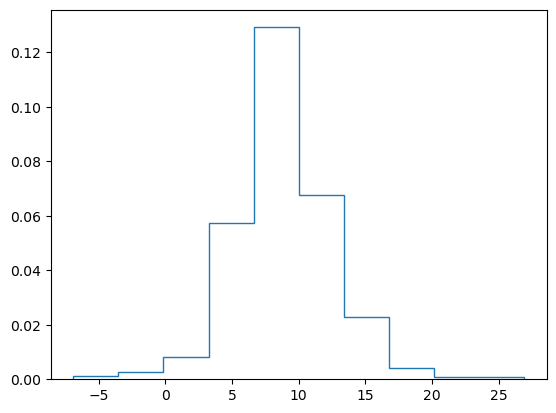

In [6]:
# 10 bins
import matplotlib.pyplot as plt
plt.hist(x,bins=10,density=True, histtype='step'); 
#density=True normalizes the histogram

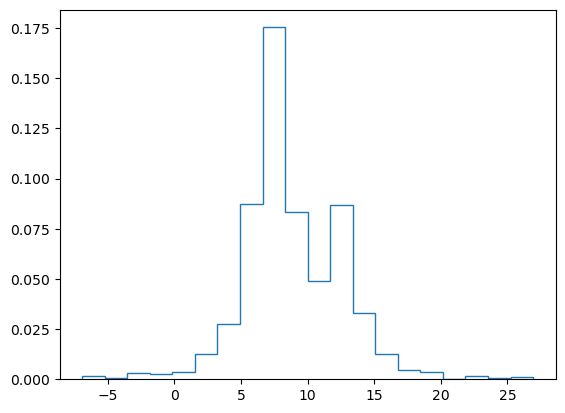

In [7]:
# 20 bins
plt.hist(x,bins=20,density=True, histtype='step'); 

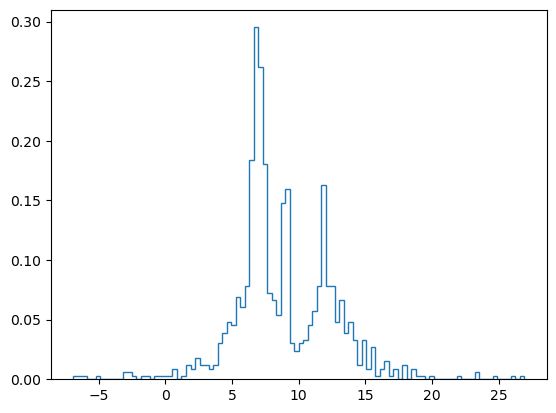

In [14]:
# 100 bins
plt.hist(x,bins=100,density=True, histtype='step'); 
# more steps shows more features

How would you characterize this distribution?  Could we reasonably think of it as a normal (Gaussian) distribution that we could characterize by some mean and standard deviation?  Maybe, but even just by looking at this plot we see that it wouldn't be a particularly good description of the data.

We find that small changes in parameters to the histogram function *significantly* change the PDF.  That's bad, because the underlying data clearly have **not** changed. One of the problems with histograms is that some bins end up with little (or no) data.  We can fix this by making **variable-width bin sizes** that have the ***same number of objects in each bin***.  How can we do this?

<font color='red'>Execute this cell</font>

In [15]:
a = np.linspace(1,42,num=42)
print(a)
print(a[::2])
print(a[::3])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42.]
[ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41.]
[ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40.]


If you are familiar with slicing, then you know that `[::2]` and `[::3]` say to count by 2 and count by 3.  But that isn't what they really do.  They say to take every other index of the array or every 3rd index of the array.  So, if your array is sorted (like `a` is), then you could use this to instead define the number of values in a bin.  That is for any given value of `M`

    bins = np.append(np.sort(x)[::M], np.max(x))
    
would give bins with `M` objects in each bin.  

So if `M=3` and $x = [1,3,5,7,9,11,13,21,29,35]$ then $bins$ = [1 7 13 35].

*Note:* you need to add the maximum value to set the right edge of the last bin.  

<font color='red'>Try it for `M=100` and `M=30` (100 and 30 objects in a bin).</font>

In [20]:
bins100 = np.append(np.sort(x)[::100], np.max(x)) #Complete
bins30 = np.append(np.sort(x)[::30],np.max(x)) #Complete
print(len(bins100),len(bins30)) # len gives the length of the array, so here how many bins with 100 or 30 data points

11 34


(-5.0, 25.0)

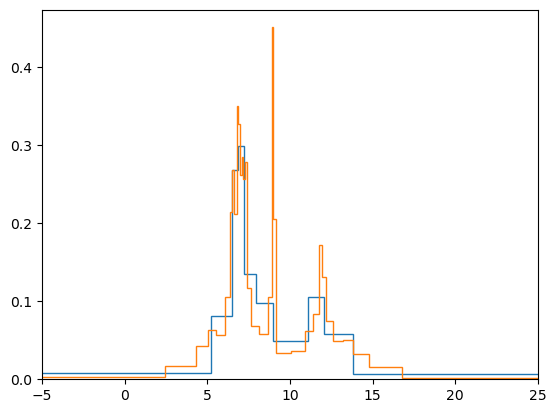

In [21]:
#Note that the underscores here are suppressing the array output
#so that we just see the plots
_ = plt.hist(x, bins=bins100, density=True, histtype="step") #Complete
_ = plt.hist(x,bins=bins30, density= True , histtype='step') #Complete
plt.xlim(-5,25)

Again, this can look pretty different depending on what the number of objects you choose as the minimum for each bin and compared to the plots above.  And it looks a lot different from the plots above.

So, what is the "right" way to set the bin size? There is no "right" way, but there are some useful rules of thumb.

**"Scott's rule"** suggests that the optimal bin width is 

$$\Delta_b = \frac{3.5\sigma}{N^{1/3}}.$$

That's great, but what if we don't know the standard deviation, $\sigma$ (e.g., if the distribution isn't really Gaussian)?  

We can then instead used the **"Freedman-Diaconis rule"**: 

$$\Delta_b = \frac{2(q_{75}-q_{25})}{N^{1/3}} = \frac{2.7\sigma_G}{N^{1/3}}.$$  

Let's try that. Remember that you can compute $\sigma_G$ using `astroML`.

In [22]:
from astroML import stats as astroMLstats
sigmaG2 = astroMLstats.sigmaG(x)
print(sigmaG2)

3.6731977984018402


<font color='red'>Now set the bin size accordingly</font>, using [np.arange](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and plot.  Make sure that you don't throw away the last object in data set (append that maximum object to the end)! 

In [27]:
binsize = 2.7*sigmaG2/(N**(1/3)) #Complete for Freedman-Diaconis Rule
print("Bin width is",binsize)
binsG = np.append(np.arange(start=x.min(), stop=x.max(), step=binsize) , x.max()) #Complete
print("Number of bins:",len(binsG))
print(binsG)

Bin width is 0.9917634055684971
Number of bins: 36
[-6.92142972e+00 -5.92966631e+00 -4.93790291e+00 -3.94613950e+00
 -2.95437610e+00 -1.96261269e+00 -9.70849286e-01  2.09141194e-02
  1.01267752e+00  2.00444093e+00  2.99620434e+00  3.98796774e+00
  4.97973115e+00  5.97149455e+00  6.96325796e+00  7.95502136e+00
  8.94678477e+00  9.93854818e+00  1.09303116e+01  1.19220750e+01
  1.29138384e+01  1.39056018e+01  1.48973652e+01  1.58891286e+01
  1.68808920e+01  1.78726554e+01  1.88644188e+01  1.98561822e+01
  2.08479456e+01  2.18397090e+01  2.28314724e+01  2.38232359e+01
  2.48149993e+01  2.58067627e+01  2.67985261e+01  2.69181842e+01]


(-5.0, 25.0)

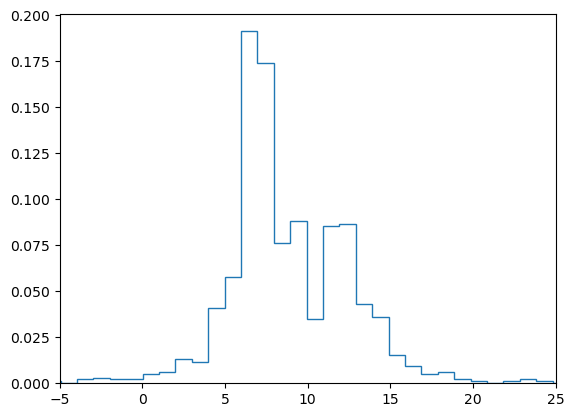

In [26]:
_ = plt.hist(x,binsG,density=True,histtype='step') #Complete   
plt.xlim(-5,25)

Did you find that tedious? Me too. Try the following shortcut.

(-5.0, 25.0)

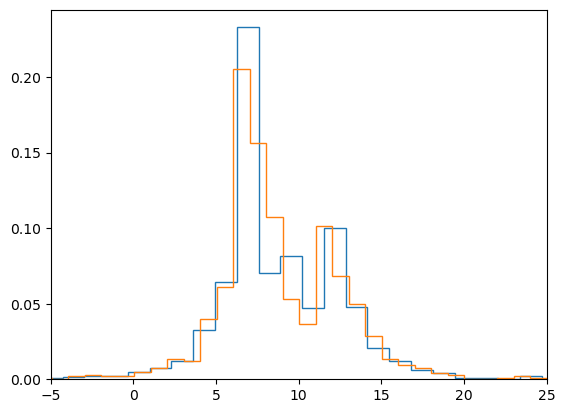

In [28]:
from astropy.visualization.hist import hist as fancyhist
_ = fancyhist(x, bins="scott", histtype="step",density=True)
_ = fancyhist(x, bins="freedman", histtype="step",density=True)
plt.xlim(-5,25)

Note that even those don't yield quite the same results!  But we can do better!

An obvious thing to do is to simply show all of the data.

<font color='red'>execute this cell</font>

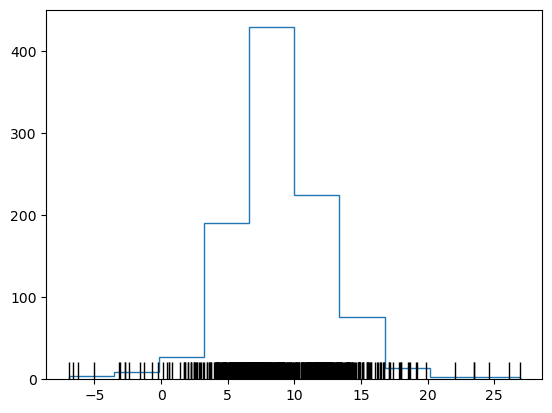

In [30]:
plt.hist(x,histtype="step")
# 0*x puts the points at y=0
plt.plot(x, 0*x, '|', color='k', markersize=25) #Note markersize is (annoyingly) in *points*

This is called a **rug plot** and now we have a better idea of where most of the data and where the gaps really are (as opposed to where the binning makes them *appear* to be).  However, the markers are all piled up, so we have lost all sense of the relative numbers of objects.  Are there ~10 at x=5 or could there be 100?

This is where **[Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE)** comes in:
- In short the idea here is to represent each data point not as a delta function, but rather as a distribution (e.g., a Gaussian).  
- Those individual distributions ("kernels") are summed up to produce the PDF.  
- One of the advantages of this is that it combines the best of 
    1. the histogram (tells us the relative height of the distribution) 
    2. the rug plot (centers the data points at the actual location of the data instead of within some arbitrary bin)

Just about any distribution can be used as the kernel, but the most common are a **Gaussian kernel** and an **Epanechnikov kernel**.  One downside of the Gaussian kernel is that the tails are technically infinite in extent.  So each point has some finite probability of being *everywhere*.  The Epanechnikov kernel has truncated wings.  

One still has the problem of deciding the width of the kernel (e.g., for the Gaussian the *"mean"* is fixed at the value of the point, but how wide should you make the Gaussian?). For now, we'll just play with the widths by hand to see what might work best.  N.B. the widths of the kernel distribution are referred to as **"bandwidth"**.

<font color='red'>execute this cell to load the KDE module</font>

In [31]:
from sklearn.neighbors import KernelDensity
xgrid = np.linspace(x.min(),x.max(),1000)  # Use this instead of 'x' for plotting

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

Before we try the Gaussian and Epanechnikov kernels, let's first start with a tophat using `kernel = "tophat"`, which will produce a plot much like the rug plot.

Start with `bandwidth=0.01`.  See what happens when you adjust this.

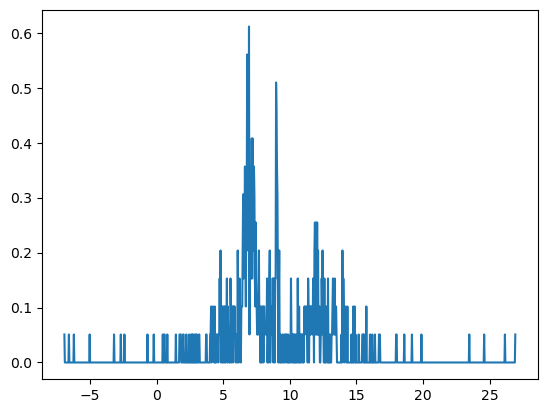

In [35]:
PDFtophat = kde_sklearn(x,bandwidth=0.01,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat) #Plot instead of hist as PDFtophat gives the bins, etc.

The defaults give a result that is essentially what you would get if you made a histogram with a really large number of bins.

Now let's compare what happens when we adjust the bandwidth (which is just the width of the kernel function).  Try 
`bandwidth=0.1` and `bandwidth=0.5`.

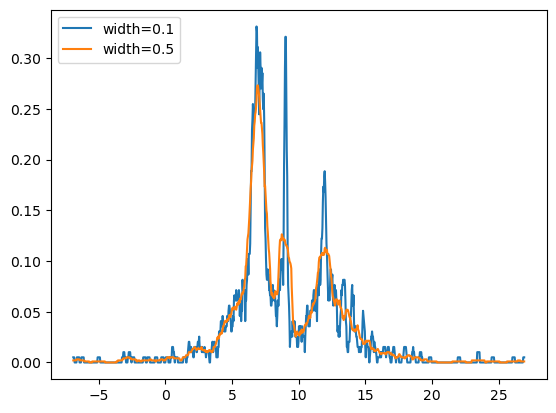

In [37]:
PDFtophat1 = kde_sklearn(x,bandwidth=0.1,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat1,label='width=0.1') #Complete

PDFtophat5 = kde_sklearn(x,bandwidth=0.5,kernel="tophat") #Complete
plt.plot(xgrid,PDFtophat5,label='width=0.5') #Complete
    
plt.legend(loc="upper left")

Now let's see what we get with the Gaussian `kernel="gaussian"` and Epanechnikov `kernel="epanechnikov"` kernels.  <font color='red'>Play with the bandwidths until you get something that looks reasonable</font> (and roughly matches) for the two kernels.  They need not be the same.

Text(0, 0.5, 'KDE')

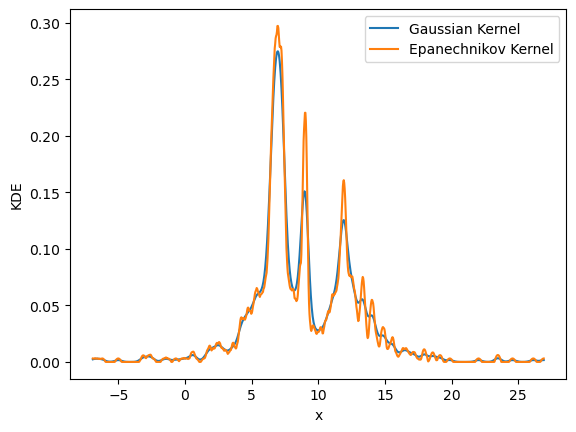

In [48]:
PDFgaussian = kde_sklearn(x,bandwidth=0.25,kernel="gaussian") #Complete 
PDFepanechnikov = kde_sklearn(x,bandwidth=0.25,kernel="epanechnikov") #Complete
plt.plot(xgrid,PDFgaussian,label="Gaussian Kernel") #Complete
plt.plot(xgrid,PDFepanechnikov,label="Epanechnikov Kernel") #Complete
plt.legend(loc=0) #Complete
plt.xlabel('x')
plt.ylabel('KDE')

This is pretty different from the histogram that we started out with, isn't it?

**HISTOGRAMS TAKE-AWAY MESSAGE:** 

Making a histogram is the first-cut we make of data, and it's certainly one of the most sensible things to try to get a feel for the data. But we can't just do it without thinking. We need to explore bin sizes and KDE smoothing bandwidths to tease out the structure in the distributions, and overcome any finite sample effects in bins by potentially having variable bin widths.

Finally, the normalized bin height of a histogram can simply be understood as

$$ f_k = \frac{n_k}{\Delta_b N}$$

where $k$ indexes the bin, $n_k$ is the occupancy number of the bin, $\Delta_b$ is the bin width, and $N$ is the total sample size. If we want to assign **uncertainties** to each bin height (not often done, but its good practice) then we can quote

$$ \sigma_k = \frac{\sqrt{n_k}}{\Delta_b N}$$